# Machine Learning for String Field Theory

*H. Erbin, R. Finotello, M. Kudrna, M. Schnabl*

## Abstract

In the framework of bosonic **Open String Field Theory** (OSFT), we consider several observables characterised by conformal weight, periodicity of the oscillations and the position of vacua in the potential for various values of truncated mass level.
We focus on the prediction of the extrapolated value for the level-$\infty$ truncation using Machine Learning (ML) techniques.

## Synopsis

In this notebook we train the machine learning algorithms on the WZW dataset.
We use a recurrent ANN with LSTM cell to predict the complex modulus and the argument angle of the truncation levels.

## General Observations

The idea is to improve the finite level predictions and reaching a result as close as possible to the extrapolated label.
We need to find a strategy to evaluate the extrapolated labels with respect to the finite level truncation.

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import os
import joblib
import time
from IPython.display import Image
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from lightgbm import LGBMRegressor
from tensorflow import keras
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical
from analysis import *

import warnings
warnings.filterwarnings('ignore', message='The objective has been evaluated at this point before.')

# set matplot
sns.set()
PREFIX = 'wzw_'
SUFFIX = '_lstm'

# set memory growth
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)
        
# set random seed
RAND = 42
np.random.seed(RAND)
tf.random.set_seed(RAND)

In [2]:
# create shortcuts for paths
proot = lambda s: os.path.join('.', s)
pdata = lambda s: os.path.join(proot('data'), s)
pimg  = lambda s: os.path.join(proot('img'), s)
pmet  = lambda s: os.path.join(proot('metrics'), s)
pmod  = lambda s: os.path.join(proot('models'), s)

## Load the Dataset

In [3]:
df = pd.read_csv(pdata('wzw.csv'))
last = 'level_10'
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 912 entries, 0 to 911
Data columns (total 38 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   k            912 non-null    float64
 1   weight       912 non-null    float64
 2   j            912 non-null    float64
 3   m            912 non-null    float64
 4   type_2       912 non-null    int64  
 5   type_4       912 non-null    int64  
 6   level_2      912 non-null    object 
 7   level_3      912 non-null    object 
 8   level_4      912 non-null    object 
 9   level_5      912 non-null    object 
 10  level_6      912 non-null    object 
 11  level_7      912 non-null    object 
 12  level_8      912 non-null    object 
 13  level_9      912 non-null    object 
 14  level_10     912 non-null    object 
 15  level_2_re   912 non-null    float64
 16  level_3_re   912 non-null    float64
 17  level_4_re   912 non-null    float64
 18  level_5_re   912 non-null    float64
 19  level_6_

In [4]:
# convert strings to complex numbers
columns = df.loc[:,df.dtypes == 'object'].columns
for c in columns:
    df[c] = df[c].astype(np.complex)

We need to:

1. define the evaluation metrics,
2. rescale the labels,
3. define the cross-validation strategy,
4. divide into training and test sets,
5. train the algorithms,
6. evaluate each algorithm.

## Evaluation Metric

In general we use the average ratio between the residuals of predicted level and the last finite truncation level:
\begin{equation}
    R(y_{true}, y_{finite}, y_{pred}) = \frac{1}{N} \sum\limits_{i = 1}^N \log_{10}\left| \frac{y_{true}^{(i)} - y_{pred}^{(i)}}{y_{true}^{(i)} - y_{finite}^{(i)}} \right|
\end{equation}
This way a negative result would represent an improvement on finite truncation levels.

## Train and Test Sets

In [5]:
train, test = train_test_split(df, train_size=0.9, shuffle=True, random_state=RAND)

X_train = train.filter(regex='k|weight|type_.*|level_[0-9]*$')
X_train.to_csv(pdata(PREFIX + 'X_train' + SUFFIX + '.csv'), index=False)
X_train = X_train.drop(columns=['k', 'weight', 'type_2', 'type_4']).values

X_test  = test.filter(regex='k|weight|type_.*|level_[0-9]*$')
X_test.to_csv(pdata(PREFIX + 'X_test' + SUFFIX + '.csv'), index=False)
X_test = X_test.drop(columns=['k', 'weight', 'type_2', 'type_4']).values

y_train = train[['exp_mod', 'exp_angle']]
y_train.to_csv(pdata(PREFIX + 'y_train' + SUFFIX + '.csv'), index=False)
y_train = y_train.values.reshape(-1,2)
y_train[:,1] = y_train[:,1] / np.pi

y_test  = test[['exp_mod', 'exp_angle']]
y_test.to_csv(pdata(PREFIX + 'y_test' + SUFFIX + '.csv'), index=False)
y_test = y_test.values.reshape(-1,2)
y_test[:,1] = y_test[:,1] / np.pi

In [6]:
print(f'Shape of the training set: X = {X_train.shape}, y = {y_train.shape}')
print(f'Shape of the test     set: X = {X_test.shape},  y = {y_test.shape}')

Shape of the training set: X = (820, 9), y = (820, 2)
Shape of the test     set: X = (92, 9),  y = (92, 2)


We also need a validation set (10% of the samples) for the neural networks:

In [7]:
train, validation = train_test_split(train, test_size=1/9, shuffle=False)

X_train_nn = train.filter(regex='k|weight|type_.*|level_[0-9]*$')
X_train_nn.to_csv(pdata(PREFIX + 'X_train_nn' + SUFFIX + '.csv'), index=False)
X_train_nn = X_train_nn.drop(columns=['k', 'weight', 'type_2', 'type_4']).values

X_val_nn  = validation.filter(regex='k|weight|type_.*|level_[0-9]*$')
X_val_nn.to_csv(pdata(PREFIX + 'X_val_nn' + SUFFIX + '.csv'), index=False)
X_val_nn = X_val_nn.drop(columns=['k', 'weight', 'type_2', 'type_4']).values

y_train_nn = train[['exp_mod', 'exp_angle']]
y_train_nn.to_csv(pdata(PREFIX + 'y_train_nn' + SUFFIX + '.csv'), index=False)
y_train_nn = y_train_nn.values.reshape(-1,2)
y_train_nn[:,1] = y_train_nn[:,1] / np.pi

y_val_nn  = validation[['exp_mod', 'exp_angle']]
y_val_nn.to_csv(pdata(PREFIX + 'y_val_nn' + SUFFIX + '.csv'), index=False)
y_val_nn = y_val_nn.values.reshape(-1,2)
y_val_nn[:,1] = y_val_nn[:,1] / np.pi

y_test_nn = y_test

In [8]:
print(f'Shape of the training   set (ANN): X = {X_train_nn.shape}, y = {y_train_nn.shape}')
print(f'Shape of the validation set (ANN): X = {X_val_nn.shape},  y = {y_val_nn.shape}')

Shape of the training   set (ANN): X = (728, 9), y = (728, 2)
Shape of the validation set (ANN): X = (92, 9),  y = (92, 2)


## Extract the Last Truncation Level

In [9]:
last_train    = X_train[:,-1].reshape(-1,)
last_train_nn = X_train_nn[:,-1].reshape(-1,)
last_val_nn   = X_val_nn[:,-1].reshape(-1,)
last_test     = X_test[:,-1].reshape(-1,)
last_test_nn  = X_test[:,-1].reshape(-1,)

## Rescale the Truncation Levels

In [10]:
lev_scaler_mod    = StandardScaler()
lev_scaler_nn_mod = StandardScaler()

# scale the cross-validation levels
X_train_mod = lev_scaler_mod.fit_transform(np.abs(X_train))
X_test_mod  = lev_scaler_mod.transform(np.abs(X_test))

# scale the neural network labels
X_train_nn_mod = lev_scaler_nn_mod.fit_transform(np.abs(X_train_nn))
X_val_nn_mod   = lev_scaler_nn_mod.transform(np.abs(X_val_nn))
X_test_nn_mod  = lev_scaler_nn_mod.transform(np.abs(X_test))

# compute the argumet angle
X_train_angle = np.angle(X_train) / np.pi
X_test_angle  = np.angle(X_test) / np.pi

# scale the neural network labels
X_train_nn_angle = np.angle(X_train_nn) / np.pi
X_val_nn_angle   = np.angle(X_val_nn) / np.pi
X_test_nn_angle  = np.angle(X_test) / np.pi

In [11]:
os.makedirs('./models', exist_ok=True)

In [12]:
# save the scalers
joblib.dump(lev_scaler_mod, pmod(PREFIX + 'levels_cv_scaler_mod' + SUFFIX + '.pkl'))
joblib.dump(lev_scaler_nn_mod, pmod(PREFIX + 'levels_nn_scaler_mod' + SUFFIX + '.pkl'))

['./models/wzw_levels_nn_scaler_mod_lstm.pkl']

## Reshape Input for LSTM

In [13]:
X_train_nn_mod = X_train_nn_mod.reshape(-1, X_train_nn_mod.shape[1], 1)
X_val_nn_mod   = X_val_nn_mod.reshape(-1, X_val_nn_mod.shape[1], 1)
X_test_nn_mod  = X_test_nn_mod.reshape(-1, X_test_nn_mod.shape[1], 1)
X_train_nn_angle = X_train_nn_angle.reshape(-1, X_train_nn_angle.shape[1], 1)
X_val_nn_angle   = X_val_nn_angle.reshape(-1, X_val_nn_angle.shape[1], 1)
X_test_nn_angle  = X_test_nn_angle.reshape(-1, X_test_nn_angle.shape[1], 1)

## Training

In [14]:
os.makedirs('./img', exist_ok=True)
os.makedirs('./metrics', exist_ok=True)

### Artificial Neural Network (w/ Keras)

In [15]:
keras.backend.clear_session()

ann_mod = keras.models.Sequential([keras.layers.Input(shape=X_train_nn_mod.shape[1:], name='input_mod'),
                                   #####################################################################
                                   keras.layers.LSTM(50, return_sequences=True),
                                   keras.layers.Dropout(0.1),
                                   #####################################################################
                                   keras.layers.LSTM(30, return_sequences=True),
                                   keras.layers.Dropout(0.15),
                                   #####################################################################
                                   keras.layers.LSTM(30, return_sequences=True),
                                   keras.layers.Dropout(0.15),
                                   #####################################################################
                                   keras.layers.LSTM(10),
                                   keras.layers.Dropout(0.1),
                                   #####################################################################
                                   keras.layers.Dense(1, name='exp_mod')
                                  ],
                                  name='wzw_mod'
                                 )
ann_angle = keras.models.Sequential([keras.layers.Input(shape=X_train_nn_mod.shape[1:], name='input_angle'),
                                     #####################################################################
                                     keras.layers.LSTM(50, return_sequences=True),
                                     keras.layers.Dropout(0.1),
                                     #####################################################################
                                     keras.layers.LSTM(30, return_sequences=True),
                                     keras.layers.Dropout(0.15),
                                     #####################################################################
                                     keras.layers.LSTM(30, return_sequences=True),
                                     keras.layers.Dropout(0.15),
                                     #####################################################################
                                     keras.layers.LSTM(10),
                                     keras.layers.Dropout(0.1),
                                     #####################################################################
                                     keras.layers.Dense(1, name='exp_angle')
                                    ],
                                    name='wzw_mod'
                                   )

ann = keras.models.Model(inputs=[ann_mod.input, ann_angle.input], outputs=[ann_mod.output, ann_angle.output])
ann.compile(optimizer=keras.optimizers.Adam(learning_rate=1.0e-3),
            loss=keras.losses.MeanSquaredError(),
            metrics=[keras.metrics.MeanSquaredError(), keras.metrics.MeanAbsoluteError()]
           )
ann.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_mod (InputLayer)          [(None, 9, 1)]       0                                            
__________________________________________________________________________________________________
input_angle (InputLayer)        [(None, 9, 1)]       0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 9, 50)        10400       input_mod[0][0]                  
__________________________________________________________________________________________________
lstm_4 (LSTM)                   (None, 9, 50)        10400       input_angle[0][0]                
______________________________________________________________________________________________

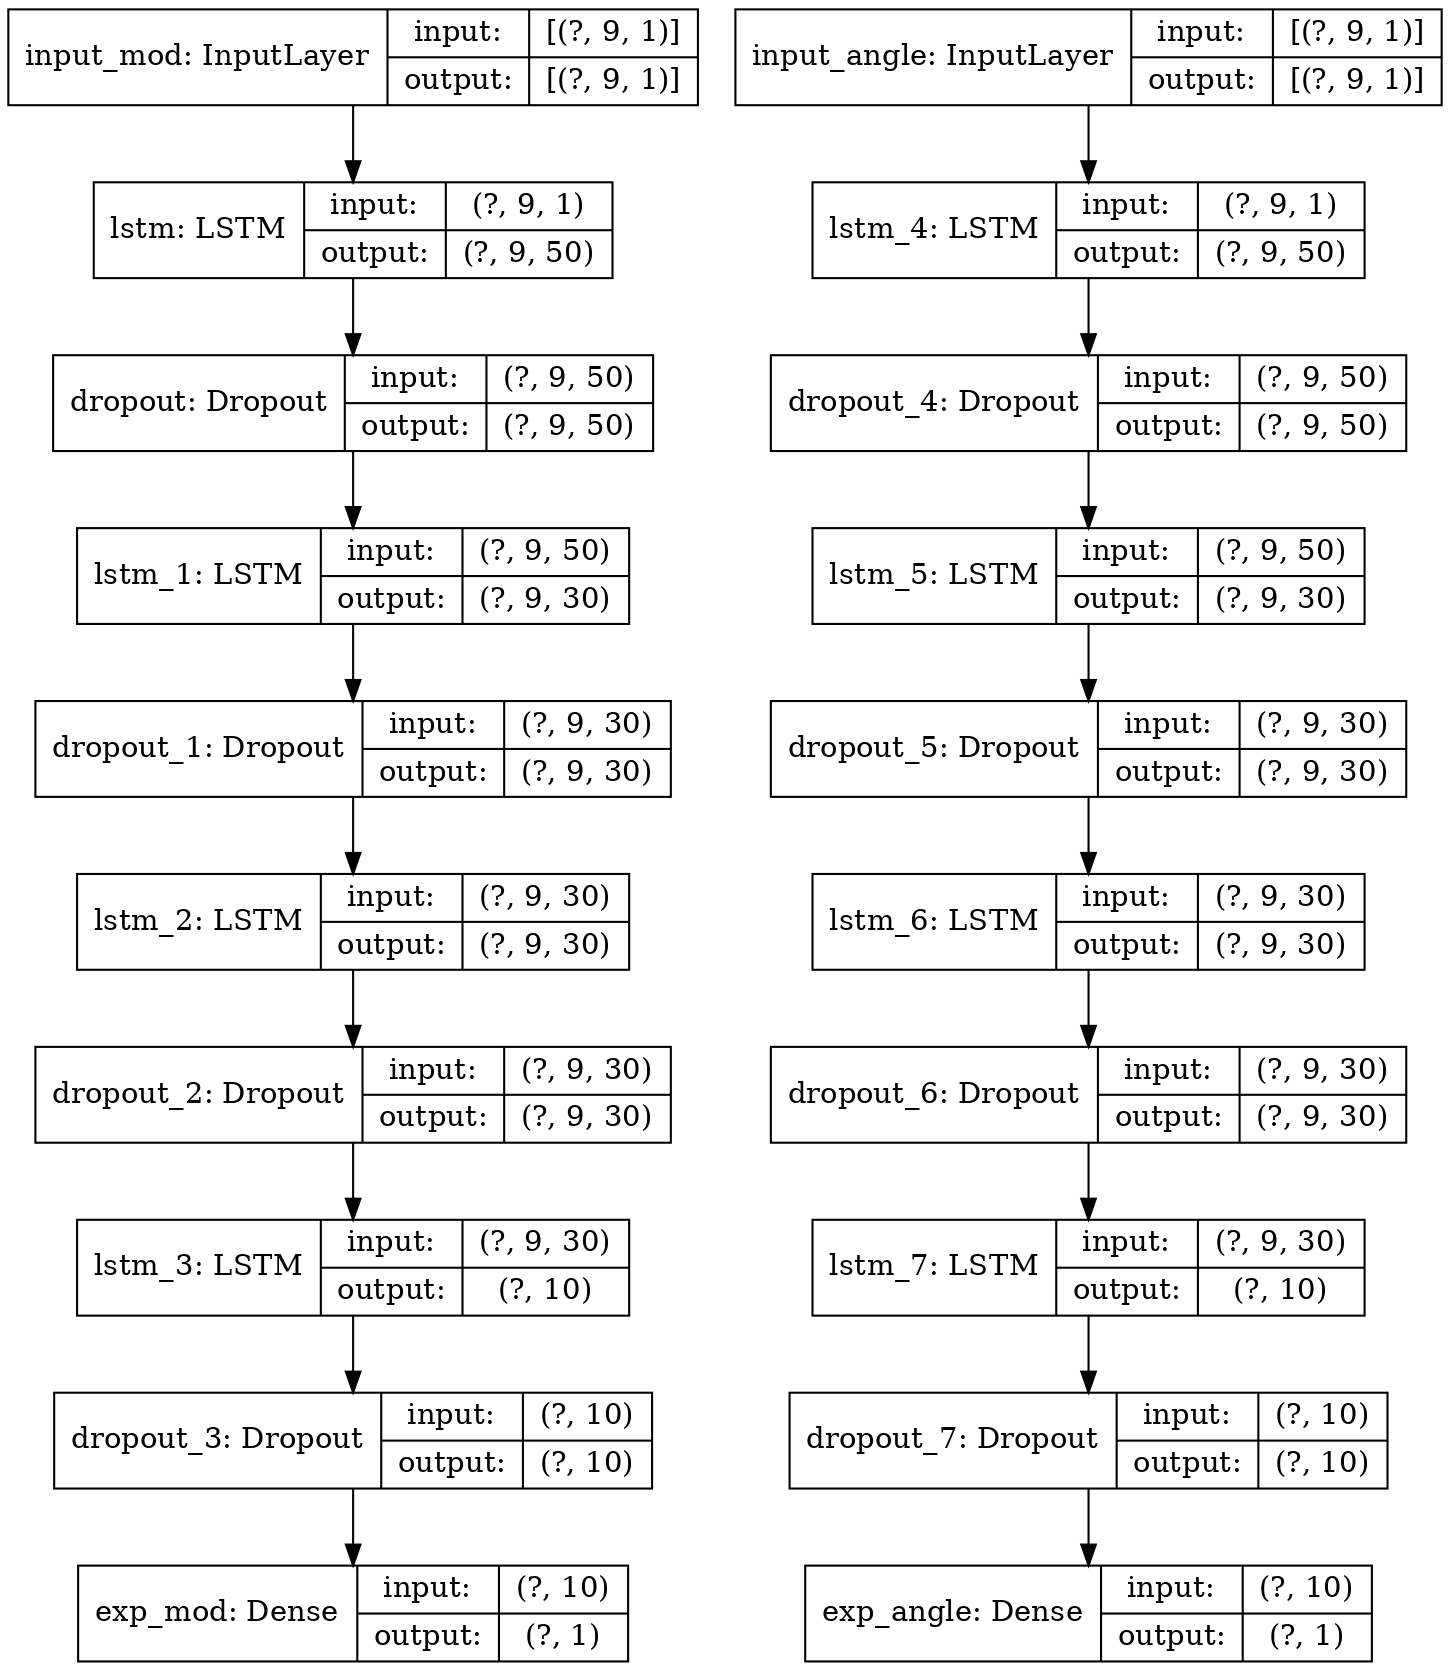

In [16]:
# save figure
ann_dot = keras.utils.model_to_dot(ann,
                                   #rankdir='LR',
                                   rankdir='TB',
                                   show_shapes=True,
                                   dpi=150)
ann_dot.write_pdf(pimg(PREFIX + 'ann_arch' + SUFFIX + '.pdf'))
Image(ann_dot.create_png(), width=320)

In [17]:
def lr_scheduler(epoch, lr):
    '''
    Schedule the learning rate:
    
    Arguments:
        epoch: the current epoch,
        lr:    the current learning rate.
    '''
    if epoch < 1000:
        return lr
    else:
        if lr <= 1.0e-6:
            return lr
        else:
            return lr * tf.math.exp(-1.0e-3)

In [18]:
t = time.time()
ann_history = ann.fit(x=[X_train_nn_mod, X_train_nn_angle],
                      y=[y_train_nn[:,0], y_train_nn[:,1]],
                      batch_size=32,
                      epochs=20000,
                      verbose=0,
                      callbacks=[keras.callbacks.EarlyStopping(patience=2500, restore_best_weights=True, verbose=0),
                                 keras.callbacks.LearningRateScheduler(lr_scheduler, verbose=0),
                                 keras.callbacks.ModelCheckpoint(pmod(PREFIX + 'ann' + SUFFIX + '.h5'), verbose=0, save_best_only=True)
                                ],
                      validation_data=([X_val_nn_mod, X_val_nn_angle], [y_val_nn[:,0], y_val_nn[:,1]])
                     )
t = time.time() - t
print(f'Training took {t:.3f} seconds.')

Training took 979.667 seconds.


In [19]:
# save and display history
ann_history_obj = pd.DataFrame(ann_history.history)
ann_history_obj.to_csv(pmod(PREFIX + 'ann_history' + SUFFIX + '.csv'), index=False)
print(f'No. of epochs: {ann_history_obj.shape[0]:d}')

No. of epochs: 3533


In [20]:
history_plots(ann_history_obj, prefix=PREFIX, suffix=SUFFIX)

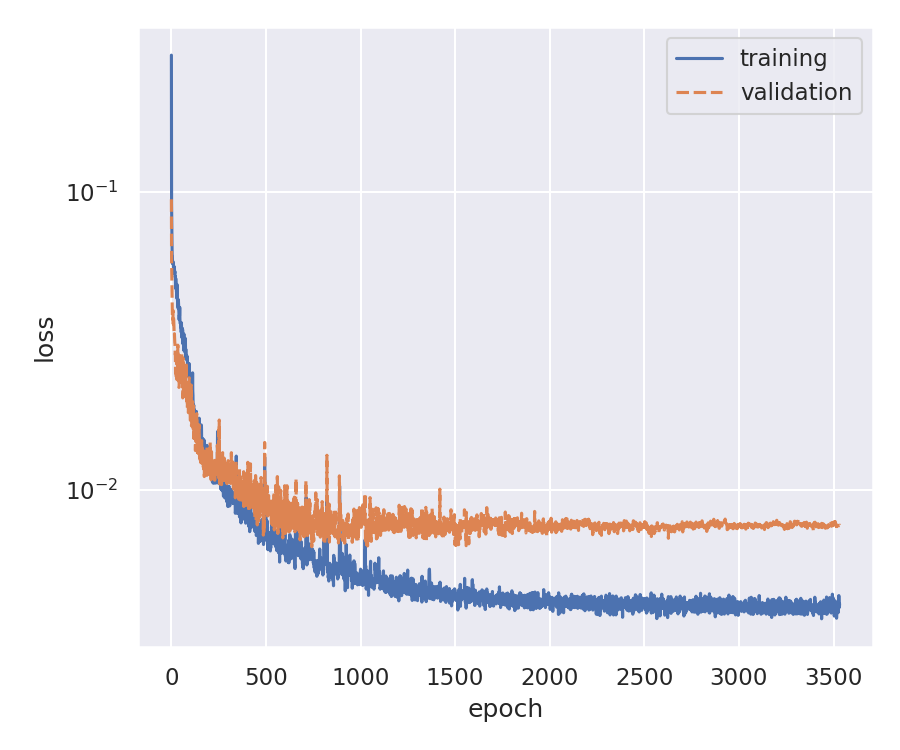

In [21]:
Image(pimg(PREFIX + 'ann_loss' + SUFFIX + '.png'), width=480)

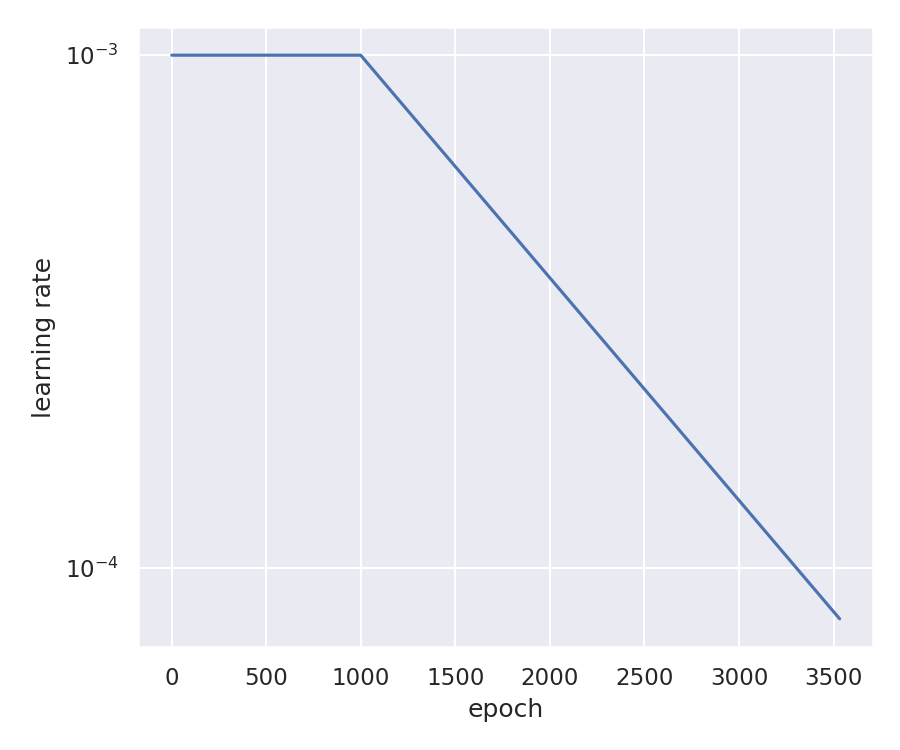

In [22]:
Image(pimg(PREFIX + 'ann_lr' + SUFFIX + '.png'), width=480)

In [23]:
train_metrics_mod = make_predictions(ann_mod,
                                     X_train_nn_mod,
                                     y_train_nn[:,0],
                                     np.abs(last_train_nn),
                                     prefix=PREFIX,
                                     suffix=SUFFIX,
                                     name='train_ann_mod',
                                     tensor=True
                                    )
val_metrics_mod   = make_predictions(ann_mod,
                                     X_val_nn_mod,
                                     y_val_nn[:,0],
                                     np.abs(last_val_nn),
                                     prefix=PREFIX,
                                     suffix=SUFFIX,
                                     name='val_ann_mod',
                                     tensor=True
                                    )
test_metrics_mod  = make_predictions(ann_mod,
                                     X_test_nn_mod,
                                     y_test_nn[:,0],
                                     np.abs(last_test_nn),
                                     prefix=PREFIX,
                                     suffix=SUFFIX,
                                     name='test_ann_mod',
                                     tensor=True
                                    )

# concatenate the prediction results
metrics_mod = pd.concat([train_metrics_mod, val_metrics_mod, test_metrics_mod], axis=0).transpose()
metrics_mod.to_csv(pmet(PREFIX + 'ann_metrics_mod' + SUFFIX + '.csv'))
metrics_mod

,train_ann_mod,val_ann_mod,test_ann_mod
mean_squared_error,0.000466,0.002710,0.005109
mean_absolute_error,0.014287,0.023848,0.031967
r2_score,0.993848,0.953439,0.918141
residual_ratio,-0.720166,-0.653704,-0.520305


In [24]:
train_metrics_angle = make_predictions(ann_angle,
                                       X_train_nn_angle,
                                       y_train_nn[:,1],
                                       np.angle(last_train_nn) / np.pi,
                                       prefix=PREFIX,
                                       suffix=SUFFIX,
                                       name='train_ann_angle',
                                       tensor=True
                                      )
val_metrics_angle   = make_predictions(ann_angle,
                                       X_val_nn_angle,
                                       y_val_nn[:,1],
                                       np.angle(last_val_nn) / np.pi,
                                       prefix=PREFIX,
                                       suffix=SUFFIX,
                                       name='val_ann_angle',
                                       tensor=True
                                      )
test_metrics_angle  = make_predictions(ann_angle,
                                       X_test_nn_angle,
                                       y_test_nn[:,1],
                                       np.angle(last_test_nn) / np.pi,
                                       prefix=PREFIX,
                                       suffix=SUFFIX,
                                       name='test_ann_angle',
                                       tensor=True
                                      )

# concatenate the prediction results
metrics_angle = pd.concat([train_metrics_angle, val_metrics_angle, test_metrics_angle], axis=0).transpose()
metrics_angle.to_csv(pmet(PREFIX + 'ann_metrics_angle' + SUFFIX + '.csv'))
metrics_angle

,train_ann_angle,val_ann_angle,test_ann_angle
mean_squared_error,0.002592,0.003699,0.002377
mean_absolute_error,0.016726,0.018946,0.018080
r2_score,0.915198,0.889447,0.932756
residual_ratio,-0.539665,-0.806434,-0.820578


In [25]:
make_plots(ann_mod, X_train_nn_mod, y_train_nn[:,0], np.abs(last_train_nn), prefix=PREFIX, suffix=SUFFIX, name='train_ann_mod')
make_plots(ann_mod, X_val_nn_mod, y_val_nn[:,0], np.abs(last_val_nn), prefix=PREFIX, suffix=SUFFIX, name='val_ann_mod')
make_plots(ann_mod, X_test_nn_mod, y_test_nn[:,0], np.abs(last_test_nn), prefix=PREFIX, suffix=SUFFIX, name='test_ann_mod')
compare_plots_val(ann_mod,
                  X_train_nn_mod, y_train_nn[:,0], np.abs(last_train_nn),
                  X_val_nn_mod, y_val_nn[:,0], np.abs(last_val_nn),
                  X_test_nn_mod, y_test_nn[:,0], np.abs(last_test_nn),
                  legend=['training', 'validation', 'test'],
                  prefix=PREFIX,
                  suffix=SUFFIX,
                  name='ann_mod'
                 )

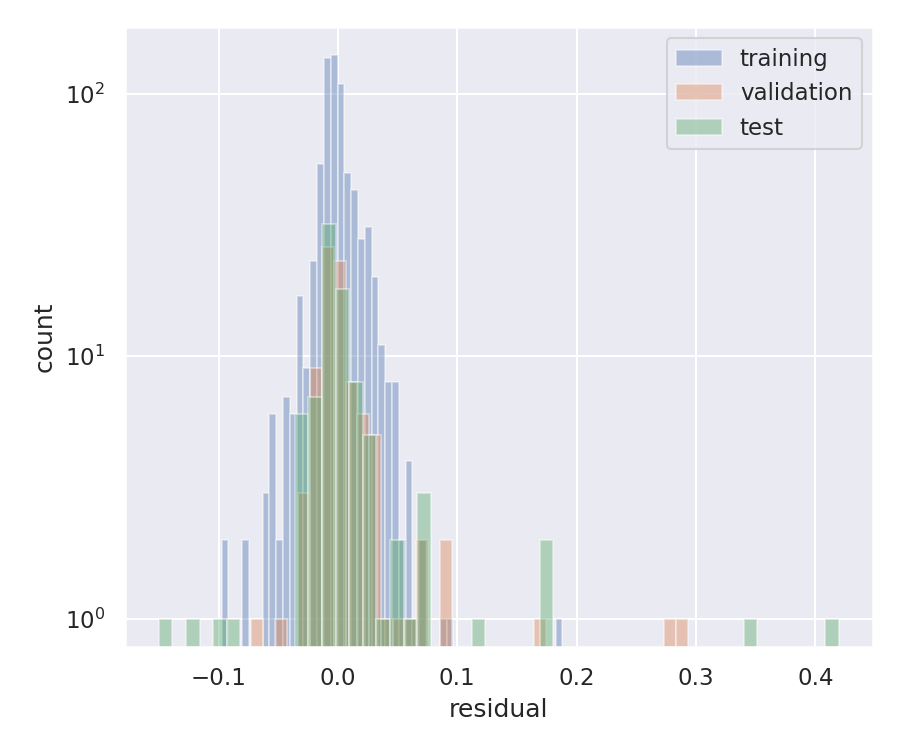

In [26]:
Image(pimg(PREFIX + 'ann_mod_residual_histogram_compare' + SUFFIX + '.png'), width=480)

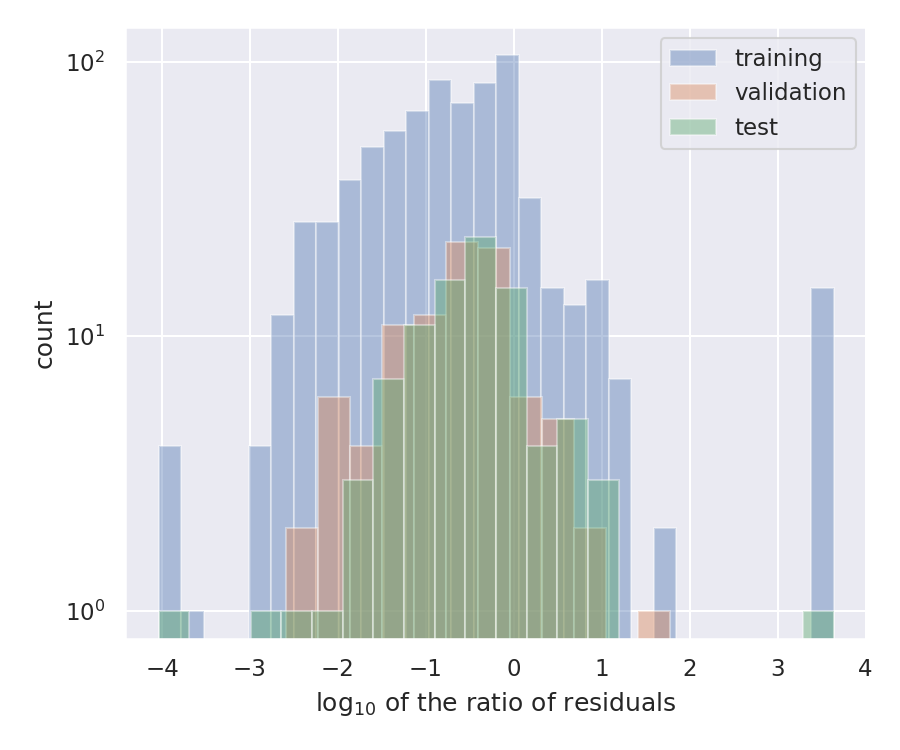

In [27]:
Image(pimg(PREFIX + 'ann_mod_ratio_histogram_compare' + SUFFIX + '.png'), width=480)

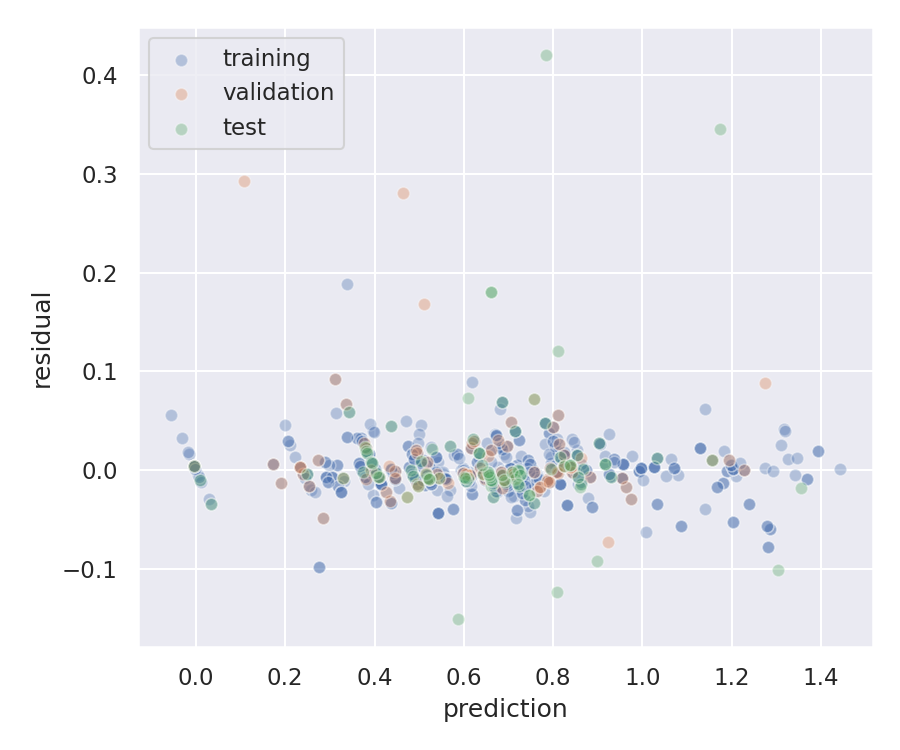

In [28]:
Image(pimg(PREFIX + 'ann_mod_residual_scatterplot_compare' + SUFFIX + '.png'), width=480)

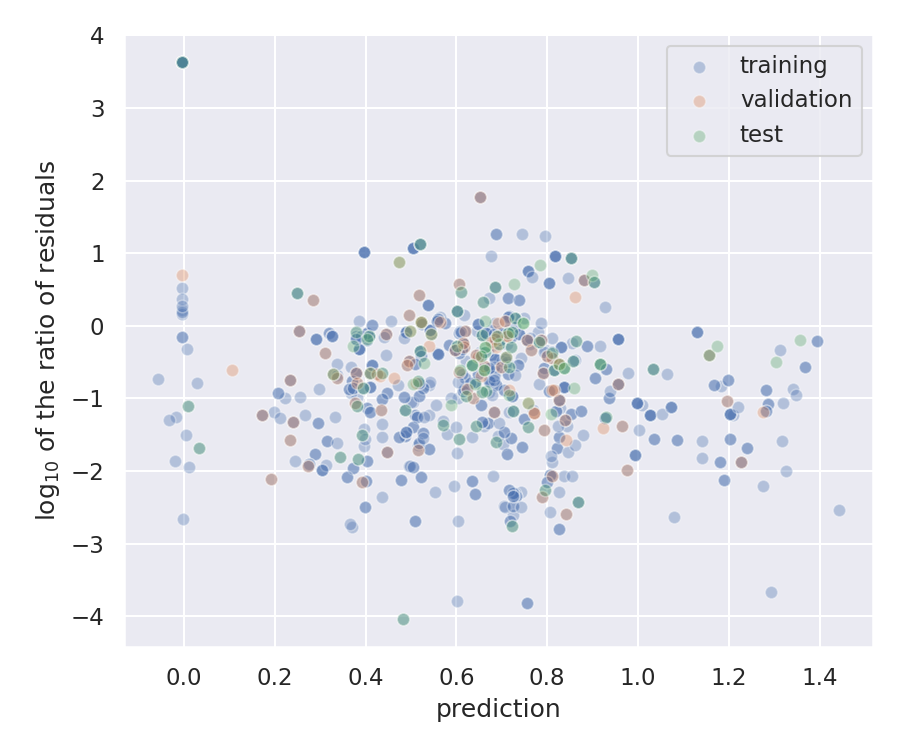

In [29]:
Image(pimg(PREFIX + 'ann_mod_ratio_scatterplot_compare' + SUFFIX + '.png'), width=480)

In [30]:
make_plots(ann_angle, X_train_nn_angle, y_train_nn[:,1], np.angle(last_train_nn), prefix=PREFIX, suffix=SUFFIX, name='train_ann_angle')
make_plots(ann_angle, X_val_nn_angle, y_val_nn[:,1], np.angle(last_val_nn), prefix=PREFIX, suffix=SUFFIX, name='val_ann_angle')
make_plots(ann_angle, X_test_nn_angle, y_test_nn[:,1], np.angle(last_test_nn), prefix=PREFIX, suffix=SUFFIX, name='test_ann_angle')
compare_plots_val(ann_angle,
                  X_train_nn_angle, y_train_nn[:,1], np.angle(last_train_nn),
                  X_val_nn_angle, y_val_nn[:,1], np.angle(last_val_nn),
                  X_test_nn_angle, y_test_nn[:,1], np.angle(last_test_nn),
                  legend=['training', 'validation', 'test'],
                  prefix=PREFIX,
                  suffix=SUFFIX,
                  name='ann_angle'
                 )

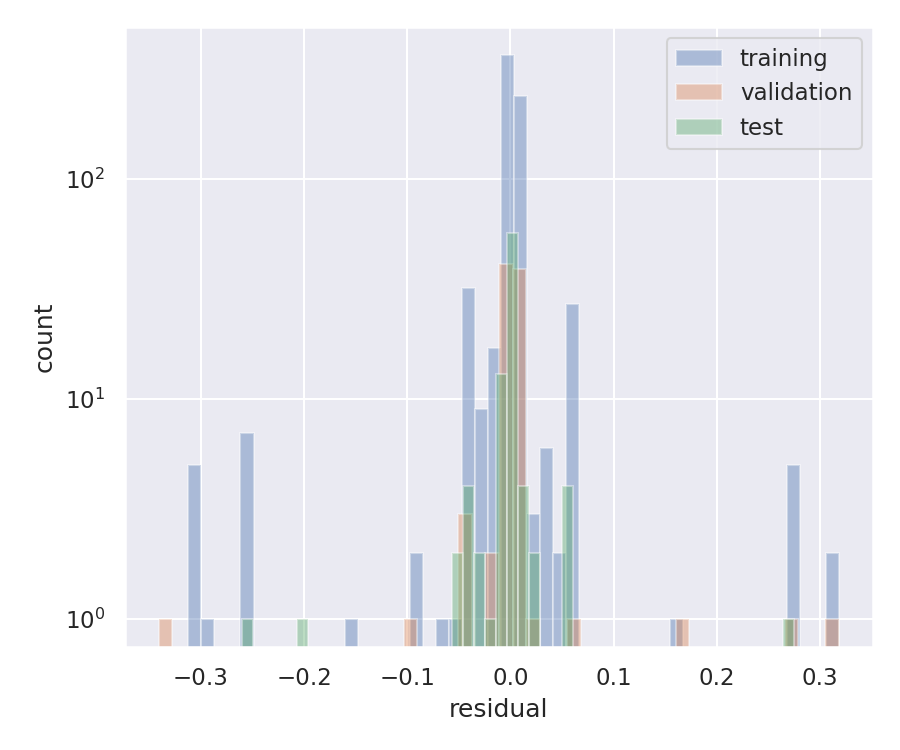

In [31]:
Image(pimg(PREFIX + 'ann_angle_residual_histogram_compare' + SUFFIX + '.png'), width=480)

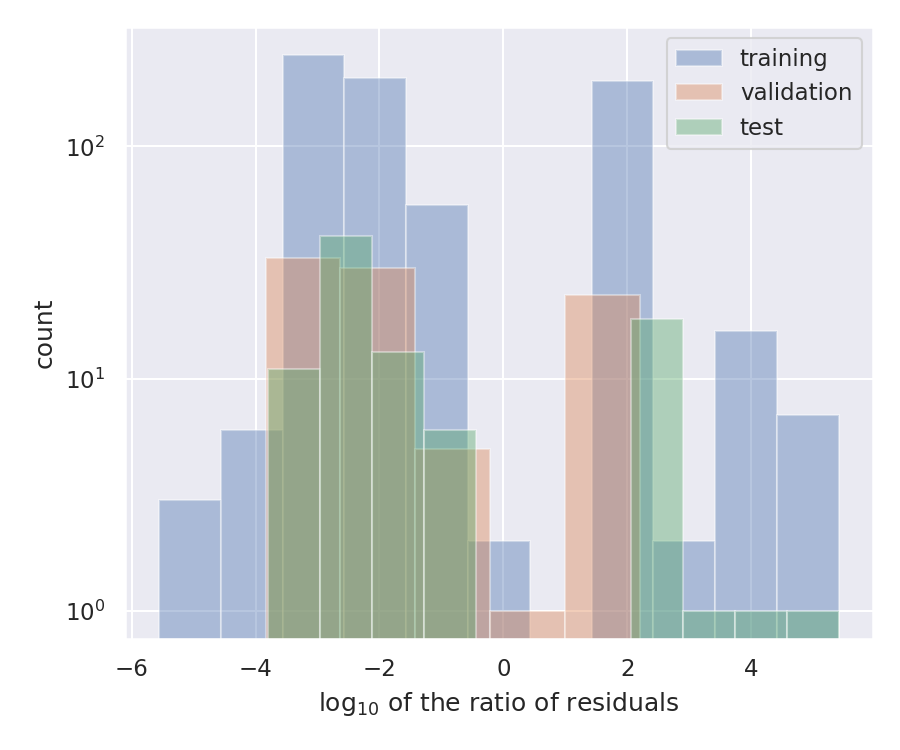

In [32]:
Image(pimg(PREFIX + 'ann_angle_ratio_histogram_compare' + SUFFIX + '.png'), width=480)

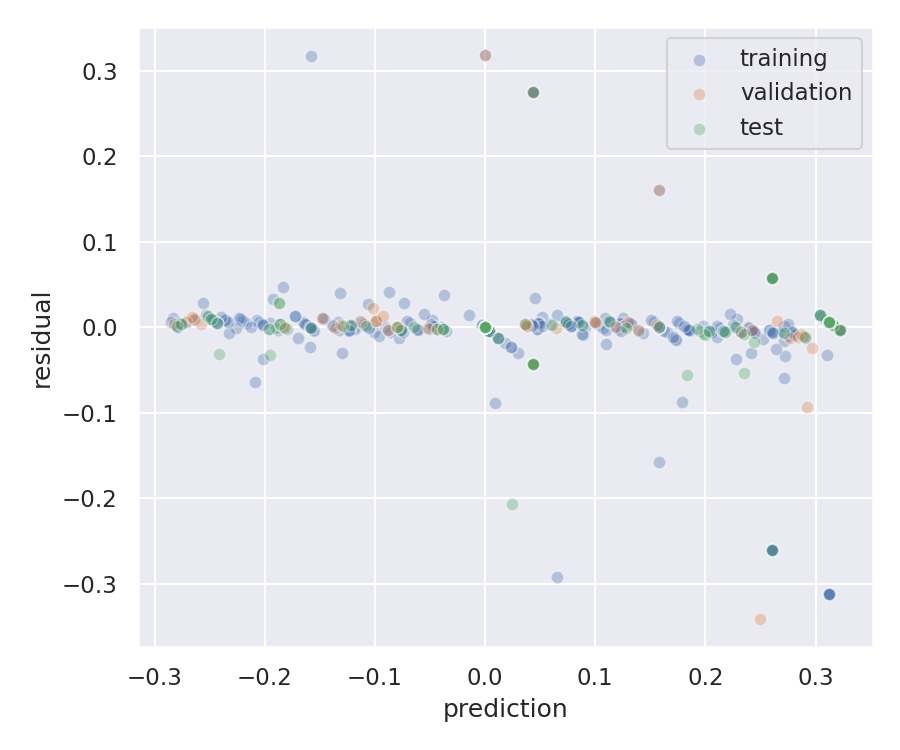

In [33]:
Image(pimg(PREFIX + 'ann_angle_residual_scatterplot_compare' + SUFFIX + '.png'), width=480)

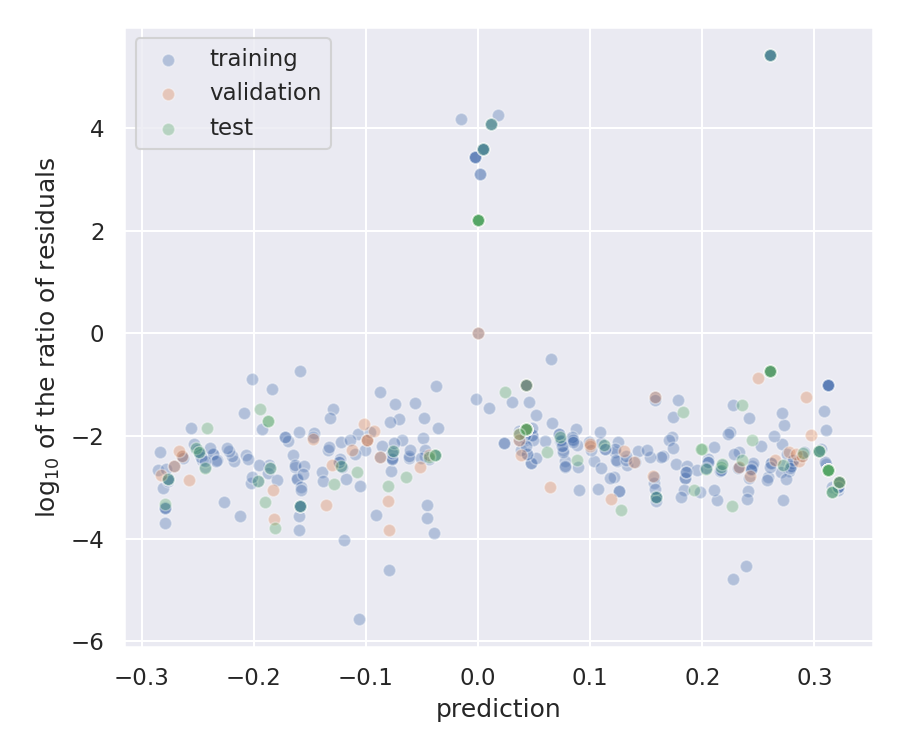

In [34]:
Image(pimg(PREFIX + 'ann_angle_ratio_scatterplot_compare' + SUFFIX + '.png'), width=480)